In [1253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint

In [527]:
df = pd.read_csv('updated_diamonds.csv')

## EDA

In [528]:
df.drop('Unnamed: 0',axis =1, inplace=True) #removing column that was basically the same as the index
df.drop_duplicates(inplace = True) #might be some duplicate rows based on the way the data was scraped (changing floor price)

In [529]:
df.info() #data types are as expected

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52461 entries, 0 to 52885
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   shape             52461 non-null  object 
 1   original_price    52461 non-null  int64  
 2   discounted_price  6796 non-null   float64
 3   carat             52461 non-null  float64
 4   cut               52461 non-null  object 
 5   color             52461 non-null  object 
 6   clarity           52461 non-null  object 
 7   polish            52461 non-null  object 
 8   symmetry          52461 non-null  object 
 9   fluorescence      52461 non-null  object 
 10  depth             52461 non-null  float64
 11  table             52461 non-null  float64
 12  lxwratio          52461 non-null  float64
 13  culet             52461 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 6.0+ MB


In [531]:
#Astor Ideal and showing up as ealAstor - need to update
df['cut'] = df['cut'].replace('ealAstor','Astor Ideal')

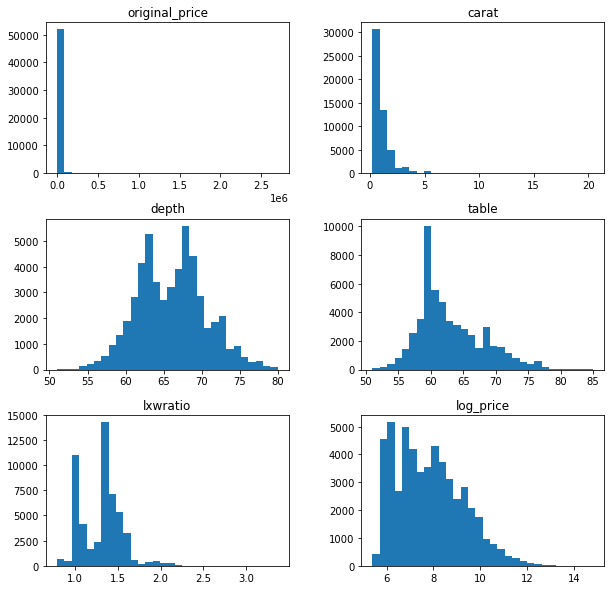

In [1335]:
df['log_price'] = np.log(df['original_price'])
df.hist(figsize=(10,10),bins=30,grid=False);

In [1171]:
df.describe()

,original_price,carat,depth,table,lxwratio,log_price
count,5.246100e+04,52461.000000,52461.000000,52461.000000,52461.000000,5.246100e+04
mean,7.941095e+03,0.993874,66.088462,62.946719,1.308527,7.941095e+03
std,2.688281e+04,0.909858,4.517800,5.039816,0.236147,2.688281e+04
min,2.210000e+02,0.230000,51.000000,51.000000,0.790000,2.210000e+02
25%,7.930000e+02,0.400000,62.700000,59.000000,1.050000,7.930000e+02
50%,2.152000e+03,0.710000,66.200000,62.000000,1.350000,2.152000e+03
75%,6.409000e+03,1.200000,68.900000,66.000000,1.440000,6.409000e+03
max,2.702260e+06,20.450000,80.000000,85.000000,3.370000,2.702260e+06


In [534]:
df.corr()

,original_price,discounted_price,carat,depth,table,lxwratio
original_price,1.000000,0.996543,0.750451,-0.001705,0.009492,-0.022267
discounted_price,0.996543,1.000000,0.821921,0.021983,0.024054,-0.041886
carat,0.750451,0.821921,1.000000,0.050836,0.015941,-0.111207
depth,-0.001705,0.021983,0.050836,1.000000,0.592803,-0.555673
table,0.009492,0.024054,0.015941,0.592803,1.000000,-0.446653
lxwratio,-0.022267,-0.041886,-0.111207,-0.555673,-0.446653,1.000000


need to remove discounted price since we are trying to predict original price or else there might be data leakage - model will have the information you are trying to predict

In [535]:
df.drop('discounted_price',axis =1,inplace = True)

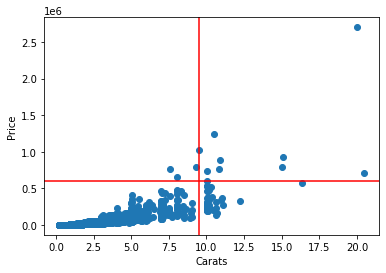

In [1315]:
#there are outliers - one diamond is almost 3 million!
fig,ax = plt.subplots()
ax.scatter(df.carat,(df.original_price))
ax.set_xlabel('Carats')
ax.set_ylabel('Price')
plt.axvline(x=9.5, color = 'r')
plt.axhline(600000, color = 'r');

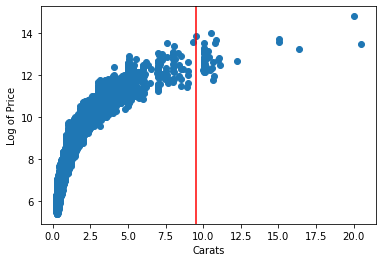

In [1310]:
fig,ax = plt.subplots()
ax.scatter(df.carat,np.log(df.original_price))
ax.set_xlabel('Carats')
ax.set_ylabel('Log of Price')
plt.axvline(x=9.5, color = 'r');

In [1327]:
print(f'Percent of data to drop: {df[(df.carat>9.5) & (df.original_price>600000)].shape[0]/df.shape[0]*100}%')

Percent of data to drop: 0.017155601303825697%


In [1337]:
df_filtered = df[(df.carat<9.5) & (df.original_price<500000)]
df_filtered

,shape,original_price,carat,cut,color,clarity,polish,symmetry,fluorescence,depth,table,lxwratio,culet,log_price
0,Emerald,221,0.30,Good,J,VS2,Very Good,Good,None,70.0,61.0,1.33,None,5.398163
1,Emerald,224,0.30,Very Good,J,SI1,Excellent,Very Good,Faint,65.9,66.0,1.42,None,5.411646
2,Emerald,224,0.30,Very Good,J,SI1,Excellent,Very Good,Faint,66.6,66.0,1.28,None,5.411646
3,Pear,225,0.30,Very Good,J,SI1,Very Good,Very Good,Faint,61.7,62.0,1.60,None,5.416100
4,Pear,226,0.30,Very Good,J,SI2,Very Good,Very Good,None,62.5,59.0,1.57,None,5.420535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52861,Emerald,439952,7.25,Very Good,D,VS1,Excellent,Very Good,None,64.4,65.0,1.43,None,12.994421
52863,Oval,464826,8.02,Very Good,E,VS1,Excellent,Very Good,None,62.2,57.0,1.38,None,13.049418
52865,Emerald,469643,8.30,Very Good,E,VS1,Excellent,Excellent,None,68.1,69.0,1.60,None,13.059728
52866,Emerald,469665,7.00,Very Good,D,FL,Excellent,Very Good,None,66.7,68.0,1.34,None,13.059775


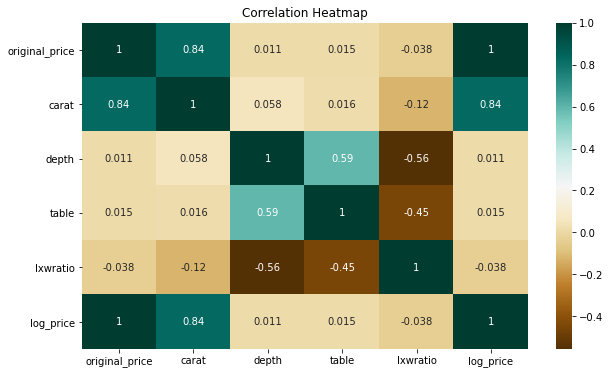

In [1207]:
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df_filtered.corr(),cmap = 'BrBG',annot = True)
heatmap.set_title('Correlation Heatmap');

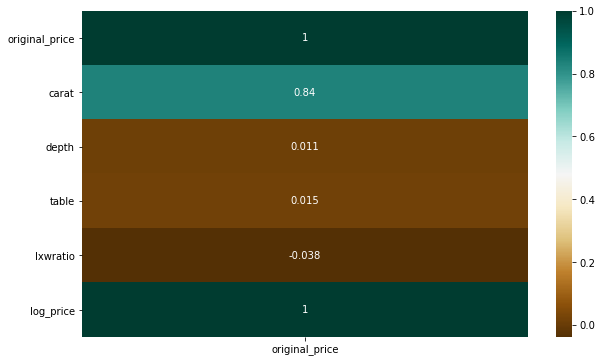

In [1209]:
plt.figure(figsize = (10,6))
sns.heatmap(df_filtered.corr()[['original_price']],cmap = 'BrBG',annot=True);

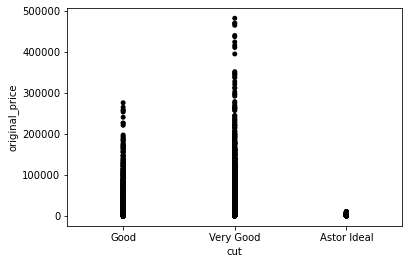

In [1213]:
sns.stripplot(data = df_filtered,
              x='cut', y='original_price', 
              order = ['Good','Very Good','Astor Ideal'],
              color = 'black', jitter=False);

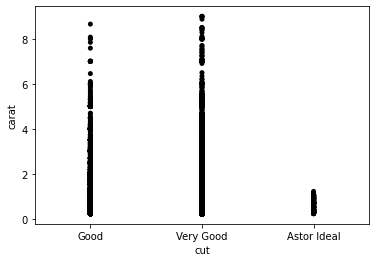

In [1214]:
sns.stripplot(data = df_filtered,
              x='cut', y='carat', 
              order = ['Good','Very Good','Astor Ideal'],
              color = 'black', jitter=False);

In [1215]:
len(df_filtered[df_filtered.cut == 'Astor Ideal']['cut'])/df.shape[0] #less than one percent of diamonds are astor ideal

0.009759630963954175

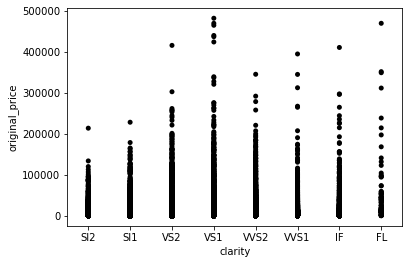

In [1216]:
sns.stripplot(data = df_filtered,
              x='clarity', y='original_price', 
              order = ['SI2','SI1','VS2','VS1','VVS2','VVS1','IF','FL'],
              color = 'black', jitter=False);

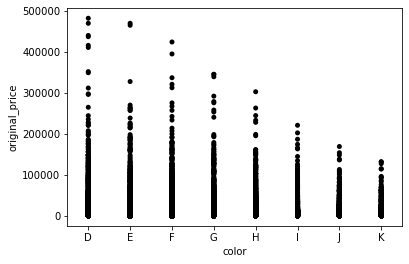

In [1225]:
sns.stripplot(data = df_filtered,
              x='color', y='original_price', 
              order = ['D', 'E','F','G','H','I','J','K'],
              color = 'black', jitter=False);

## Linear Regression Model

## Predicting log of price

In [1532]:
linreg = LinearRegression()

X = df.drop(['original_price','log_price'],axis = 1)
y = df.log_price
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [1533]:
X_train_1 = pd.get_dummies(X_train)
X_test_1 = pd.get_dummies(X_test)
y_predicted_1 = linreg.fit(X_train_1,y_train).predict(X_test_1)



print(f'Train RMSE: {(-cross_val_score(linreg,X_train_1,y_train,scoring="neg_root_mean_squared_error")).mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_predicted_1))}')
print(f'Train R2: {cross_val_score(linreg,X_train_1,y_train,scoring="r2").mean()}')
print(f'Test R2: {r2_score(y_test,y_predicted_1)}')
print(f'Mean Absolute Percentage Error: {np.exp(mean_absolute_percentage_error(y_test,y_predicted_1))}')

Train RMSE: 0.6298053082173724
Test RMSE: 0.6518507243833425
Train R2: 0.7997746229652567
Test R2: 0.7902609398216868
Mean Absolute Percentage Error: 1.064385780991823


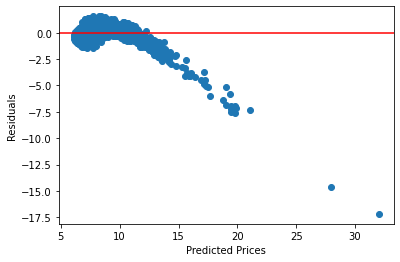

In [1534]:
predicted = linreg.fit(X_train_1,y_train).predict(X_test_1)
residuals = y_test - predicted

fig,ax = plt.subplots()
ax.scatter(predicted ,residuals)
plt.axhline(y=0, color = 'r')
ax.set_xlabel('Predicted Prices')
ax.set_ylabel('Residuals');

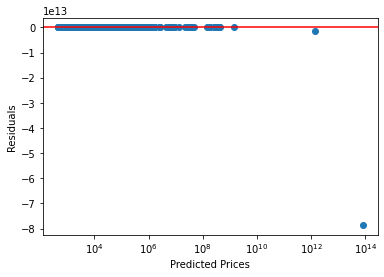

In [1535]:
predicted = linreg.fit(X_train_1,y_train).predict(X_test_1)
residuals = np.exp(y_test) - np.exp(predicted)

fig,ax = plt.subplots()
ax.scatter(np.exp(predicted),residuals)
plt.axhline(y=0, color = 'r')
plt.xscale('log')
ax.set_xlabel('Predicted Prices')
ax.set_ylabel('Residuals');

## Predicting log of price with outliers removed

In [1528]:
linreg = LinearRegression()

X = df_filtered.drop(['original_price','log_price'],axis = 1)
y = df_filtered.log_price
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [1529]:
X_train_1 = pd.get_dummies(X_train)
X_test_1 = pd.get_dummies(X_test)
y_predicted_1 = linreg.fit(X_train_1,y_train).predict(X_test_1)



print(f'Train RMSE: {(-cross_val_score(linreg,X_train_1,y_train,scoring="neg_root_mean_squared_error")).mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_predicted_1))}')
print(f'Train R2: {cross_val_score(linreg,X_train_1,y_train,scoring="r2").mean()}')
print(f'Test R2: {r2_score(y_test,y_predicted_1)}')
print(f'Mean Absolute Percentage Error: {np.exp(mean_absolute_percentage_error(y_test,y_predicted_1))}')

Train RMSE: 0.5705840169262928
Test RMSE: 0.5865062452511492
Train R2: 0.8350225170410879
Test R2: 0.8240487956978838
Mean Absolute Percentage Error: 1.0607904835693949


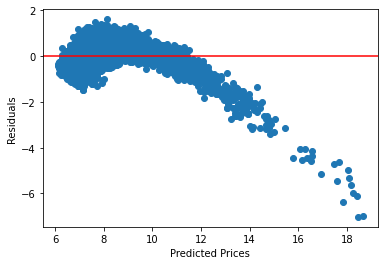

In [1531]:
predicted = linreg.fit(X_train_1,y_train).predict(X_test_1)
residuals = y_test - predicted

fig,ax = plt.subplots()
ax.scatter(predicted,residuals)
plt.axhline(y=0, color = 'r')
ax.set_xlabel('Predicted Prices')
ax.set_ylabel('Residuals');

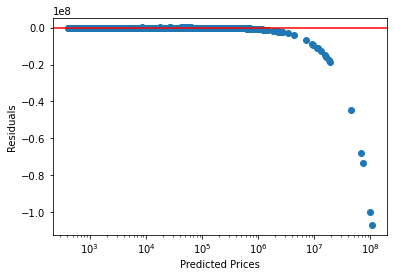

In [1522]:
predicted = linreg.fit(X_train_1,y_train).predict(X_test_1)
residuals = np.exp(y_test) - np.exp(predicted)

fig,ax = plt.subplots()
ax.scatter(np.exp(predicted),residuals)
plt.axhline(y=0, color = 'r')
plt.xscale('log')
ax.set_xlabel('Predicted Prices')
ax.set_ylabel('Residuals');

### Removing outliers

In [1475]:
linreg = LinearRegression()

X = df_filtered.drop(['original_price','log_price'],axis = 1)
y = df_filtered.original_price
X_train, X_test, y_train, y_test = train_test_split(X,y)

Try using all features

In [1499]:
X_train_1 = pd.get_dummies(X_train)
X_test_1 = pd.get_dummies(X_test)
y_predicted_1 = linreg.fit(X_train_1,y_train).predict(X_test_1)
print(f'Train RMSE: {-cross_val_score(linreg,X_train_1,y_train,scoring="neg_root_mean_squared_error").mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,y_predicted_1))}')
print(f'Train R2: {cross_val_score(linreg,X_train_1,y_train,scoring="r2").mean()}')
print(f'Test R2: {linreg.score(X_test_1,y_test)}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test,y_predicted_1)}')

Train RMSE: 0.5767670324848627
Test RMSE: 0.569210613815734
Train R2: 0.8304919976519646
Test R2: 0.8367212849211053
Mean Absolute Percentage Error: 0.05816423453700561


In [1287]:
scaler = StandardScaler()
scaler.fit(X_train_1)
X_train_s = scaler.transform(X_train_1)
linreg.fit(X_train_1,y_train)

np.abs(linreg.coef_)

array([20074.91596133,   152.47356935,   121.66553516,  2547.81376433,
        1191.91406857,  2090.30041796,  2030.41192169,   105.24178408,
         305.57440933,   567.51168315,   329.46493602,  3727.79345934,
        2037.61152212,  3202.24253157,  2069.88677247,  1132.3557591 ,
        4068.85629139,  3860.26847867,  2931.04071464,  1444.4586806 ,
         110.55716831,  1702.49862086,  3746.74338588,  6965.93932686,
       16431.878926  ,    23.29691646,  3537.47650068,  6092.13733784,
        1471.49113229,  2776.0308154 ,  1067.37455157,  1510.66550468,
         422.11517655,    20.734547  ,   442.84972355,  1577.3310489 ,
         956.05368048,   621.27736842,  2762.33045311,  1443.86821475,
        1494.08371776,   305.73554428,   700.12164001,  3121.49565708,
          51.52590758,   930.18256862,   781.31692465,  6155.94727271,
        1915.59605664,  1530.15850316,   379.59440424,  3452.2832492 ,
        2564.78161259,   784.75389829,  1406.96199947])

Look at coefficients to see if there is some insight from feature importance

In [1288]:
coefficients = pd.concat([pd.DataFrame(X_train_1.columns, columns = ['features']),pd.DataFrame(np.transpose(np.abs(linreg.coef_)),columns = ['coefs'])], axis = 1)
coefficients.sort_values(by=['coefs'],ascending=False)

,features,coefs
0,carat,20074.915961
24,clarity_FL,16431.878926
23,color_K,6965.939327
47,fluorescence_Very Strong Blue,6155.947273
27,clarity_SI2,6092.137338
16,color_D,4068.856291
17,color_E,3860.268479
22,color_J,3746.743386
11,shape_Princess,3727.793459
26,clarity_SI1,3537.476501


In [1478]:
X_train_2 = X_train[['carat','cut','clarity', 'color']]
X_train_2 = pd.get_dummies(X_train_2)
X_test_2 = X_test[['carat','cut','clarity', 'color']]
X_test_2 = pd.get_dummies(X_test_2)
y_predicted_2 = linreg.fit(X_train_2,y_train).predict(X_test_2)
print(f'Train RMSE: {-cross_val_score(linreg,X_train_2,y_train,scoring="neg_root_mean_squared_error").mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,y_predicted_2))}')
print(f'Train R2: {cross_val_score(linreg,X_train_2,y_train,scoring="r2").mean()}')
print(f'Train R2: {r2_score(y_test,y_predicted_2)}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test,y_predicted_2)}')

Train RMSE: 9527.642176907168
Test RMSE: 9687.07371844203
Train R2: 0.737447182613451
Train R2: 0.7316435737133925
Mean Absolute Percentage Error: 3.6333682346407974


The plot below exhibits “heteroscedasticity,” meaning that the residuals get larger as the prediction moves from small to large (or from large to small).

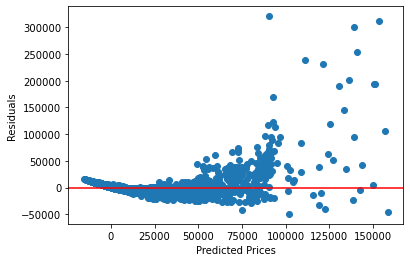

In [1284]:
predicted = linreg.fit(X_train_1,y_train).predict(X_test_1)
residuals = y_test - predicted

fig,ax = plt.subplots()
ax.scatter(predicted,residuals)
plt.axhline(y=0, color = 'r')
ax.set_xlabel('Predicted Prices')
ax.set_ylabel('Residuals');

## Random Forest

In [1500]:
#using all features
rf= RandomForestRegressor(n_jobs=-1).fit(X_train_1,y_train)
print(f'Train RMSE: {-cross_val_score(rf,X_train_1,y_train, scoring="neg_root_mean_squared_error").mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,rf.predict(X_test_1)))}')
print(f'Train R2: {cross_val_score(rf,X_train_1,y_train,scoring="r2").mean()}')
print(f'Test R2: {r2_score(y_test,rf.predict(X_test_1))}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test,y_predicted_1)}')

Train RMSE: 0.10868097546923627
Test RMSE: 0.10579941466059527
Train R2: 0.9939805311226717
Test R2: 0.9943590776072421
Mean Absolute Percentage Error: 0.05816423453700561


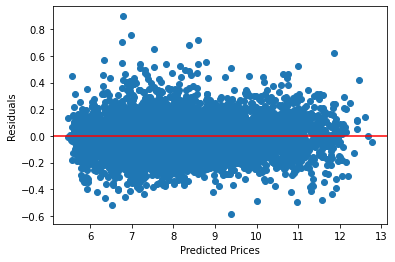

In [1501]:
predicted = rf.fit(X_train_1,y_train).predict(X_test_1)
residuals = y_test - predicted

fig,ax = plt.subplots()
ax.scatter(predicted,residuals)
plt.axhline(y=0, color = 'r')
ax.set_xlabel('Predicted Prices')
ax.set_ylabel('Residuals');

Text(0, 0.5, 'percent error')

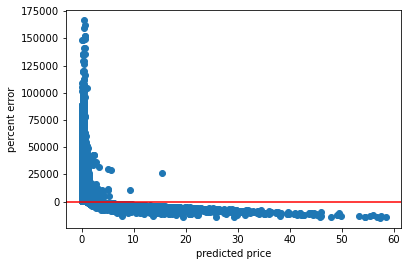

In [1490]:
percent_error = np.abs(y_test - y_predicted_1)/y_test
fig,ax = plt.subplots()
ax.scatter(y_predicted_1,percent_error)
ax.set_xlabel('predicted price')
plt.axhline(y=0, color = 'r')
ax.set_ylabel('percent error')

In [1070]:
#remove features/only using 4c's - improved but still overfitting to training data
rf= RandomForestRegressor(n_jobs=-1).fit(X_train_2,y_train)
print(f'Train RMSE: {-cross_val_score(rf,X_train_2,y_train, scoring="neg_root_mean_squared_error").mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,rf.predict(X_test_2)))}')

Train RMSE: 6694.9343785587935
Test RMSE: 18279.272717774107


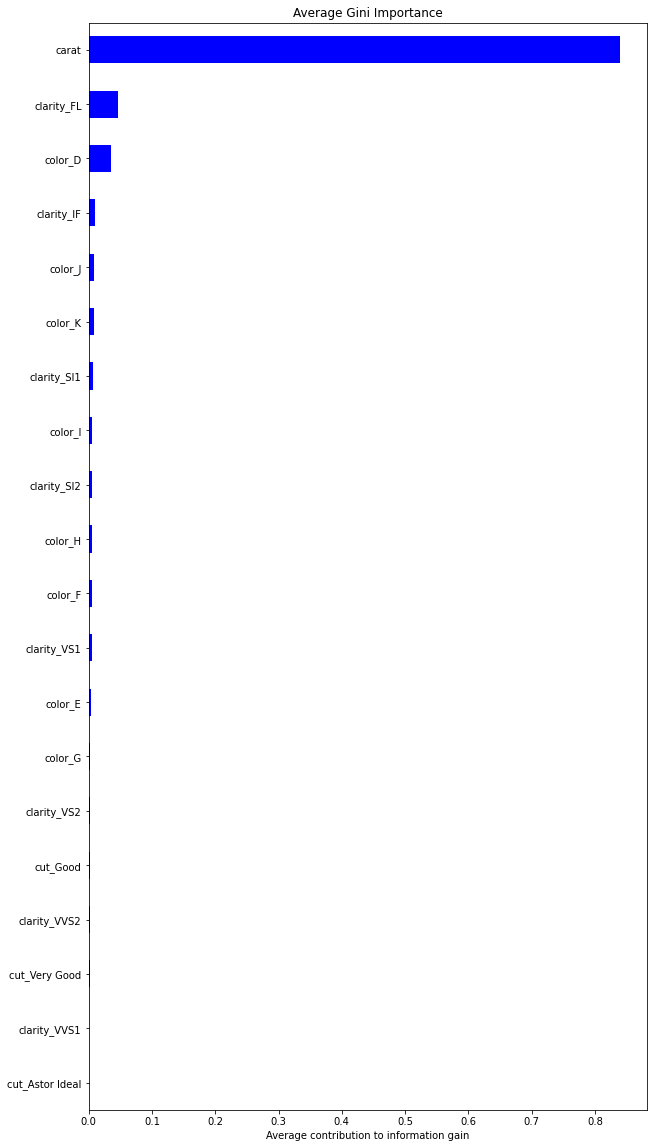

In [1071]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=X_train_2.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,20),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

In [1063]:
#creating a random grid
n_estimators = [int(x) for x in np.linspace(start=200,stop=500, num =4)]
max_features = ['auto','sqrt']
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]

random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [1068]:
rf = RandomForestRegressor(max_depth = 20, n_jobs = -1 )
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv=3,n_jobs=-1)
rf_random.fit(X_train_2,y_train)

KeyboardInterrupt: 

In [1065]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto'}

In [ ]:
rf = RandomForestRegressor(n_estimators = 300, min_samples_split =2, min_samples_leaf = 1, max_features = 'auto', max_depth = 20).fit(X_train_2,y_train)
print(f'Train RMSE: {-cross_val_score(rf,X_train_2,y_train, scoring="neg_root_mean_squared_error").mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,rf.predict(X_test_2)))}')

A Random Forest Regressor with 1 # trees gets a score of 11176.095897196257
A Random Forest Regressor with 5 # trees gets a score of 8552.025555891069
A Random Forest Regressor with 10 # trees gets a score of 7412.964709538256
A Random Forest Regressor with 20 # trees gets a score of 7510.149420683639
A Random Forest Regressor with 50 # trees gets a score of 7076.474429446709
A Random Forest Regressor with 100 # trees gets a score of 7110.977498026284
A Random Forest Regressor with 200 # trees gets a score of 7030.275635041355
A Random Forest Regressor with 500 # trees gets a score of 7071.017200483923
A Random Forest Regressor with 1000 # trees gets a score of 7053.021918440689


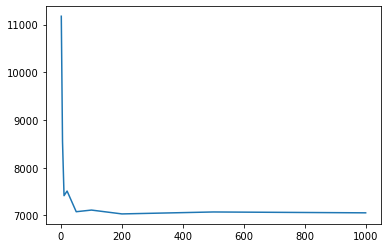

In [1042]:
trees = [1, 5, 10, 20, 50, 100, 200, 500, 1000]
scores = []

for t in trees:
    model = RandomForestRegressor(n_estimators=t, n_jobs = -1)
    score = -cross_val_score(model,X_train_1,y_train, scoring="neg_root_mean_squared_error").mean()
    print('A Random Forest Regressor with {} # trees gets a score of {}'
          .format(t,score))
    scores.append(score)

fig, ax = plt.subplots()
ax.plot(trees, scores)

In [1048]:
depth = [1, 5, 10, 20, 50, 100]
scores = []
for d in depth:
    model = RandomForestRegressor(max_depth=d, n_jobs = -1)
    score = -cross_val_score(model,X_train_1,y_train, scoring="neg_root_mean_squared_error").mean()
    print('A Random Forest Regressor with max_depth of: {} gets a score of {}'
          .format(d,score))
    scores.append(score)

A Random Forest Regressor with max_depth of: 1 gets a score of 17415.272001701796
A Random Forest Regressor with max_depth of: 5 gets a score of 8860.923002807176
A Random Forest Regressor with max_depth of: 10 gets a score of 7477.358983369717
A Random Forest Regressor with max_depth of: 20 gets a score of 7001.749641253237
A Random Forest Regressor with max_depth of: 50 gets a score of 7174.962332790188
A Random Forest Regressor with max_depth of: 100 gets a score of 7005.565785643569


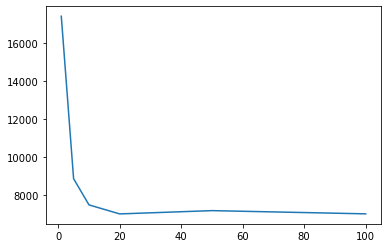

In [1049]:
fig, ax = plt.subplots()
ax.plot(depth, scores)